# Can we get a small fingerprint that encodes a PAHs with small information loss?

A fingerprint is a compact and fixed-size representation of a molecule's structural features or properties that encode complex molecular structures into numerical vectors, allowing for efficient comparison, similarity assessment, and searching of molecules in large databases. Fingerprints capture various aspects of a molecule, such as the presence or absence of certain substructures, atom types, bond types, and other molecular descriptors. there are different types of fingerprints, such as daylight-like fingerprints, circular fingerprints, extended-connectivity fingerprints, Atom Pairs Fingerprints, and topological fingerprints. In the following document we discuss the creation of a prototype of a daylight-like fingerprint that encodes substructural motif of PAHs. Additionally we highlights the future work that needs to be done to improve the fingerprint.

In [68]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

import pandas as pd
import numpy as np

# imprt defaultdict
from collections import defaultdict

# show multiple output in jupyter notebbok
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import mols2grid

## Dataset
The COMPAS-2D dataset served as the foundational resource for the fingerprint development. This dataset encompasses the structures and various electronic properties of 52,000 heteroatom-substituted polycyclic aromatic hydrocarbons (hPAHs). Each molecule is annotated with a range of descriptors, notably including the SMILES representation of the molecule itself, as well as the SMILES representation of its Murcko scaffold. These annotations will be utilized to generate the substructure patterns required for constructing the fingerprint.

In [80]:
df = pd.read_pickle('.tempdata/compas-2D.pkl')

# Substructures of PAHs
To establish the collection of substructures that will be incorporated into the fingerprint, the first step involves identifying the most prevalent substructures found within the dataset. Given that the dataset encompasses a considerable 52,000 molecules, a comprehensive examination of all molecules for this purpose is unfeasible. Instead, we will adopt the Murcko scaffold of each molecule as a point of reference.

The Murcko scaffold embodies the essential structural framework of a molecule, derived by excluding all side chains and heteroatoms from the molecule's structure. Serving as a valuable tool, the Murcko scaffold facilitates the recognition of a molecule's core structure, often a pivotal feature. This scaffold effectively captures the arrangement of molecular annulations, and it is anticipated that limiting the analysis to molecules with up to 4 rings will yield a substantial amount of meaningful information.

However, it is worth noting that, as our molecules belong to the category of hPAHs, the Murcko scaffold alone might not suffice to distinguish molecules exhibiting identical annulation patterns but differing in heteroatom content. In addressing this challenge, we will construct SMARTS patterns that encompass hPAHs featuring up to 5 rings.

The entirety of our dataset encompasses a total of 81 distinct Murcko scaffolds, each containing up to 5 rings. Moreover, the dataset includes 306 hPAHs with up to 5 rings within the COMPAS-2D repository. The subsequent section provides an illustration of the structural compositions of these 306 hPAHs, each exhibiting a configuration of up to 5 rings.

## Substructures pattern generations

To generate SMARTS queries that matches the Murcko scaffolds and aforementioned substructures, the following functions were employed:

The `get_smarts_from_mol` function takes the SMILES of a molecule as input and returns a SMARTS representation that describes the molecule. The SMARTS code is designed to capture the overall arrangement of atoms and bonds, without emphasizing specific bond types, while still retaining essential atom-type information.

The `get_smarts_from_scaffold` function performs a comparable task, but with a focus on the core structure of the molecule. It generates a SMARTS representation that captures the general arrangement of atoms and bonds within the molecule's backbone, without taking into account the specific atom and bond types.

In [81]:
# molecules up to 5 rings in compas-2D
mols2grid.display(df.query('rings < 5').sort_values('rings'),n_cols=7,smiles_col = 'smiles',tooltip=['name'],subset=['img'])

MolGridWidget()

In [83]:
def get_smarts_from_mol(smi: str) -> str:
    """
    Get a "generalized" smarts query from the smiles of a molecule. Generalized means that
    the query will match any any bond type but retain atom types.

    Parameters:
    ----------
    smi: str
        smiles string of a molecule

    Returns:
    -------
    sma: str
        smarts string of a molecule

    Usage:
    -----
    >>> get_smarts_from_mol('C1=CC2=CC=CC=C2C=C1')
    ... '[#6]1~[#6]~[#6]2~[#6]~[#6]~[#6]~[#6]~[#6]~2~[#6]~[#6]~1'
    >>> get_smarts_from_mol('B1C=CBC2=CC=CC=C12')
    ... '[#5]1~[#6]~[#6]~[#5]~[#6]2~[#6]~[#6]~[#6]~[#6]~[#6]~2~1
    >>> get_smarts_from_mol('B1=CC=BC2=CC=CC=C12')
    ... '[#5]1~[#6]~[#6]~[#5]~[#6]2~[#6]~[#6]~[#6]~[#6]~[#6]~1~2'

    """
    # get the molecule from the smiles
    m = Chem.MolFromSmiles(smi)

    # get the smarts from the molecule
    sma = Chem.MolToSmarts(m)

    # generalize the Carbon atom type
    sma = sma.replace('#6H','#6')
    
    # generalize the bond types
    sma = sma.replace(':','~')
    sma = sma.replace('-','~')
    sma = sma.replace('=','~')

    return sma

def get_smarts_from_scaffold(smi: str)-> str:
    """
    Get a "generalized" smarts query from a molecule's Murcko scaffold. Generalized means that
    the query will match any any bond type and any atom types.
    
    Parameters:
    ----------
    smi: str
        smiles string of a molecule

    Returns:
    -------
    sma: str
        smarts string of a molecule

    Usage:
    -----
    >>> get_smarts_from_mol('C1CC2CCCCC2CC1')
    ... '*1~*~*2~*~*~*~*~*~2~*~*~1'
    """
    # get the molecule from the smiles
    m = Chem.MolFromSmiles(smi)
    
    # get the smarts from the molecule
    sma = Chem.MolToSmarts(m)
    
    # generalize the Carbon atom type to any atom type
    sma = sma.replace('[#6]','*')

    # generalize the bond types
    sma = sma.replace('-','~')

    return sma

## Fingerprint generation

The `get_fingerprint` function takes a molecule's SMILES as input and returns a fingerprint vector that encodes the molecule's substructures. The function first generates checks for the presence of each substructure pattern within the molecule, and then returns a sparse vector that encodes which substructures are present in the molecule. The substructures are stored in the `smarts_filter` list and are obtained using the `get_smarts_from_mol` and `get_smarts_from_scaffold` functions on the compas-2D dataset. 

In [ ]:
smarts_filters = []
smarts_filters += list(df.query('rings < 5')['scaffold'].apply(get_smarts_from_scaffold).unique())
smarts_filters += list(df.query('rings < 5')['smiles'].apply(get_smarts_query).unique())
smarts_patterns = {i: Chem.MolFromSmarts(sma) for i, sma in enumerate(smarts_filters) if Chem.MolFromSmarts(sma) is not None}
print(len(smarts_filters), len(smarts_patterns))

## Testing the fingerprint
A set of 7 molecules were defined to test the fingerprint. The selection was made to include molecules very similars to test the fingerprint's ability to distinguish between them. An additional molecule was included to test the fingerprint's ability to distinguish between very different molecules. The Jaccard similarity between the fingerprint of each molecule was used to assess the fingerprint's ability to distinguish between molecules.

0

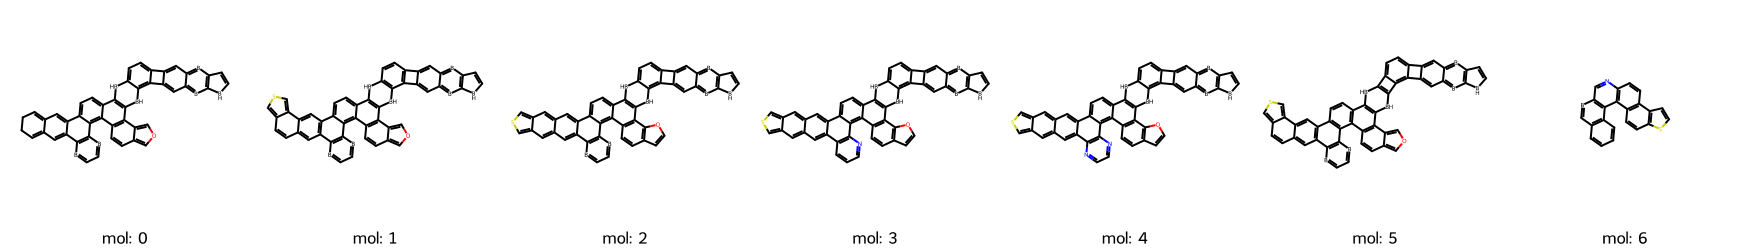

In [93]:
# Define the Test set
test_smis = 'B1C=CC2=C1B=C1C=C3C(=CC1=B2)C1=CC=C2BC4=C(BC2=C31)C1=C(C=CC2=COC=C12)C1=C2C3=C(B=CC=B3)C3=CC5=CCCC=C5C=C3C2=CC=C41.B1C=CC2=C1B=C1C=C3C(=CC1=B2)C1=C3C2=C(BC3=C(B2)C2=C(C=CC4=COC=C24)C2=C4C5=C(B=CC=B5)C5=C(C=C6C7=CSC=C7C=CC6=C5)C4=CC=C32)C=C1.B1C=CC2=C1B=C1C=C3C(=CC1=B2)C1=CC=C2BC4=C(BC2=C31)C1=C(C=CC2=C1OC=C2)C1=C2C3=C(B=CC=B3)C3=CC5=CC6=CSC=C6C=C5C=C3C2=CC=C41.B1C=CC2=C1B=C1C=C3C(=CC1=B2)C1=CC=C2BC4=C(BC2=C31)C1=C(C=CC2=C1OC=C2)C1=C2C(=CC=C41)C1=CC3=CC4=CSC=C4C=C3C=C1C1=C2N=CC=C1.B1C=CC2=C1B=C1C=C3C(=CC1=B2)C1=CC=C2BC4=C(BC2=C31)C1=C(C=CC2=C1OC=C2)C1=C2C(=CC=C41)C1=CC3=CC4=CSC=C4C=C3C=C1C1=C2N=CC=N1.B1C=CC2=C1B=C1C=C3C(=CC1=B2)C1=CC=C2C4=C(BC5=C(B4)C4=C(C6=C5C5=COC=C5C=C6)C5=C(C=C4)C4=C(C=C6C=CC7=CSC=C7C6=C4)C4=C5B=CC=B4)C2=C31.S1C=CC2=C1C=CC1=C2C=CC2=C1C1=C(B=CC3=C1C=CC=C3)C=N2'
test_mols = [Chem.MolFromSmiles(smi) for smi in test_smis.split('.')]
lgnd_mols = [f"mol: {i}" for i in range(len(test_mols))]

# generate a template to align all molecules
template = Chem.MolFromSmarts('[*]~1~[*]~[*]~2~[*]~[*]~[*]~3~[*](~[*]~[*]~[*]~4~[*]~[*]~[*]~5~[*]~[*]~[*]~6~[*]~[*]~[*]~[*]~[*]~6~[*]~5~[*]~3~4)~[*]~2~[*]~1')

# perform the alignment
AllChem.Compute2DCoords(template)
for mol in test_mols:
  _ = AllChem.GenerateDepictionMatching2DStructure(mol, template)

# draw the molecules
Draw.MolsToGridImage(test_mols, molsPerRow=7, subImgSize=(250, 250),
                 useSVG=True, legends=lgnd_mols)

In [89]:
from typing import List
def get_fingerprint(mol:Chem.Mol)->List[int]:
    """
    Get a fingerprint from a molecule using the smarts patterns defined in the global variable `smarts_patterns`.

    Parameters:
    ----------
    mol: rdkit.Chem.rdchem.Mol
        rdkit molecule object
                
    Returns:
    -------
    fps: List[int]
        List of bits On (1) for each smarts pattern in `smarts_patterns`
    
    Usage:
    -----
    >>> get_fingerprint(Chem.MolFromSmiles('c1ccc2c(c1)ccc1c3ccccc3ccc21'))
    ... [3, 18, 25]
    """
    global smarts_patterns
    return [k for k,v in smarts_patterns.items() if mol.HasSubstructMatch(v)]

fps = [get_fingerprint(mol) for mol in test_mols]
for fp in fps: print(fp)

[3, 6, 11, 12, 17, 18, 19, 20, 25, 28, 29, 32, 33, 37, 38, 57, 58, 61, 70, 111, 147]
[3, 6, 7, 11, 12, 17, 18, 19, 20, 25, 28, 29, 32, 33, 37, 38, 57, 58, 61, 70, 111, 147]
[3, 6, 11, 12, 17, 18, 19, 20, 22, 25, 28, 29, 32, 33, 37, 38, 57, 58, 61, 70, 111, 147]
[3, 6, 11, 12, 17, 18, 19, 20, 22, 25, 28, 29, 32, 33, 37, 38, 57, 58, 61, 70, 111, 147]
[3, 6, 11, 12, 17, 18, 19, 20, 22, 25, 28, 29, 32, 33, 37, 38, 57, 58, 61, 70, 111, 147]
[3, 6, 7, 11, 12, 17, 18, 19, 20, 25, 28, 29, 33, 37, 38, 58, 70, 79, 111]
[3, 11, 17, 18, 29, 58, 85]


**Aligned FPs**

```
mol 0: [3, 6,    11, 12, 17, 18, 19, 20, 25,     28, 29, 32, 33, 37, 38, 57, 58, 61, 70,     111, 147]
mol 1: [3, 6, 7, 11, 12, 17, 18, 19, 20, 25,     28, 29, 32, 33, 37, 38, 57, 58, 61, 70,     111, 147]
mol 2: [3, 6,    11, 12, 17, 18, 19, 20, 22, 25, 28, 29, 32, 33, 37, 38, 57, 58, 61, 70,     111, 147]
mol 3: [3, 6,    11, 12, 17, 18, 19, 20, 22, 25, 28, 29, 32, 33, 37, 38, 57, 58, 61, 70,     111, 147]
mol 4: [3, 6,    11, 12, 17, 18, 19, 20, 22, 25, 28, 29, 32, 33, 37, 38, 57, 58, 61, 70,     111, 147]
mol 5: [3, 6, 7, 11, 12, 17, 18, 19, 20, 25,     28, 29,     33, 37, 38,     58,     70, 79, 111     ]
mol 6: [3,       11,     17, 18,                     29,                     58,     85              ]
```

## Jaccard/Tanimoto Similarity

The aforementioned fingerprint alignment provides an intuitive approach for comparing the similarity between two molecules. Nevertheless, the Jaccard/Tanimoto similarity offers a more robust metric for assessing the resemblance between two fingerprints. This similarity measure is defined as the ratio of common substructures shared by two molecules to the total count of substructures present in both molecules. Below is the Jaccard/Tanimoto similarity between the seven molecules:

|         | 0      | 1      | 2      | 3      | 4      | 5      | 6      |
|---------|--------|--------|--------|--------|--------|--------|--------|
| **0**   |        |        |        |        |        |        |        |
| **1**   | 0.9545 |        |        |        |        |        |        |
| **2**   | 0.9545 | 0.9130 |        |        |        |        |        |
| **3**   | 0.9545 | 0.9130 | 1.0000 |        |        |        |        |
| **4**   | 0.9545 | 0.9130 | 1.0000 | 1.0000 |        |        |        |
| **5**   | 0.7391 | 0.7826 | 0.7083 | 0.7083 | 0.7083 |        |        |
| **6**   | 0.2727 | 0.2609 | 0.2609 | 0.2609 | 0.2609 | 0.3000 |        |


Furthermore, an figure depicting all pairs withs its similarity is provided below. The figure visually showcases the fingerprint's capability to differentiate between highly similar molecules, exemplified by the distinction between molecules 2 and 1, as well as molecules 3 and 0. The fingerprint is also able to distinguish between very different molecules, such as molecules all molecules and 6. However, the fingerprint is not able to distinguish between molecules 4 and 2. This is likely due to the fact that there is no substructure that is present in one molecule and absent in the other. This might be a reason to include more substructures. However, it is important to notice that clashes between structures might occur for dayligth-like fingerprints. 

In [50]:
# calc Jaccard Similarity bewtween sparse vectors
def calc_jaccard_similarity(sparse_vector1: List[int], sparse_vector2: List[int]) -> float:
    """
    Calculate Jaccard Similarity bewtween sparse vectors.
    
    Parameters:
    ----------
    sparse_vector1: List[int]
        List of bits On (1) for molecule 1
    sparse_vector2: List[int]
        List of bits On (1) for molecule 2

    Returns:
    -------
    jaccard_similarity: float
        Jaccard Similarity between molecule 1 and molecule 2 rounded to 4 decimal places

    Usage:
    -----
    >>> calc_jaccard_similarity([1,2,3],[1,2,3])
    ... 1.0
    >>> calc_jaccard_similarity([1,2,3],[1,2,4])
    ... 0.6667
    """
    sparse_vector1 = set(sparse_vector1)
    sparse_vector2 = set(sparse_vector2)
    return round(len(sparse_vector1.intersection(sparse_vector2)) / len(sparse_vector1.union(sparse_vector2)),4)

simmat = np.zeros((len(test_mols),len(test_mols)))
for i in range(len(test_mols)):
    for j in range(len(test_mols)):
        simmat[i,j] = calc_jaccard_similarity(fps[i],fps[j])
simmat

array([[1.    , 0.9545, 0.9545, 0.9545, 0.9545, 0.7391, 0.2727],
       [0.9545, 1.    , 0.913 , 0.913 , 0.913 , 0.7826, 0.2609],
       [0.9545, 0.913 , 1.    , 1.    , 1.    , 0.7083, 0.2609],
       [0.9545, 0.913 , 1.    , 1.    , 1.    , 0.7083, 0.2609],
       [0.9545, 0.913 , 1.    , 1.    , 1.    , 0.7083, 0.2609],
       [0.7391, 0.7826, 0.7083, 0.7083, 0.7083, 1.    , 0.3   ],
       [0.2727, 0.2609, 0.2609, 0.2609, 0.2609, 0.3   , 1.    ]])

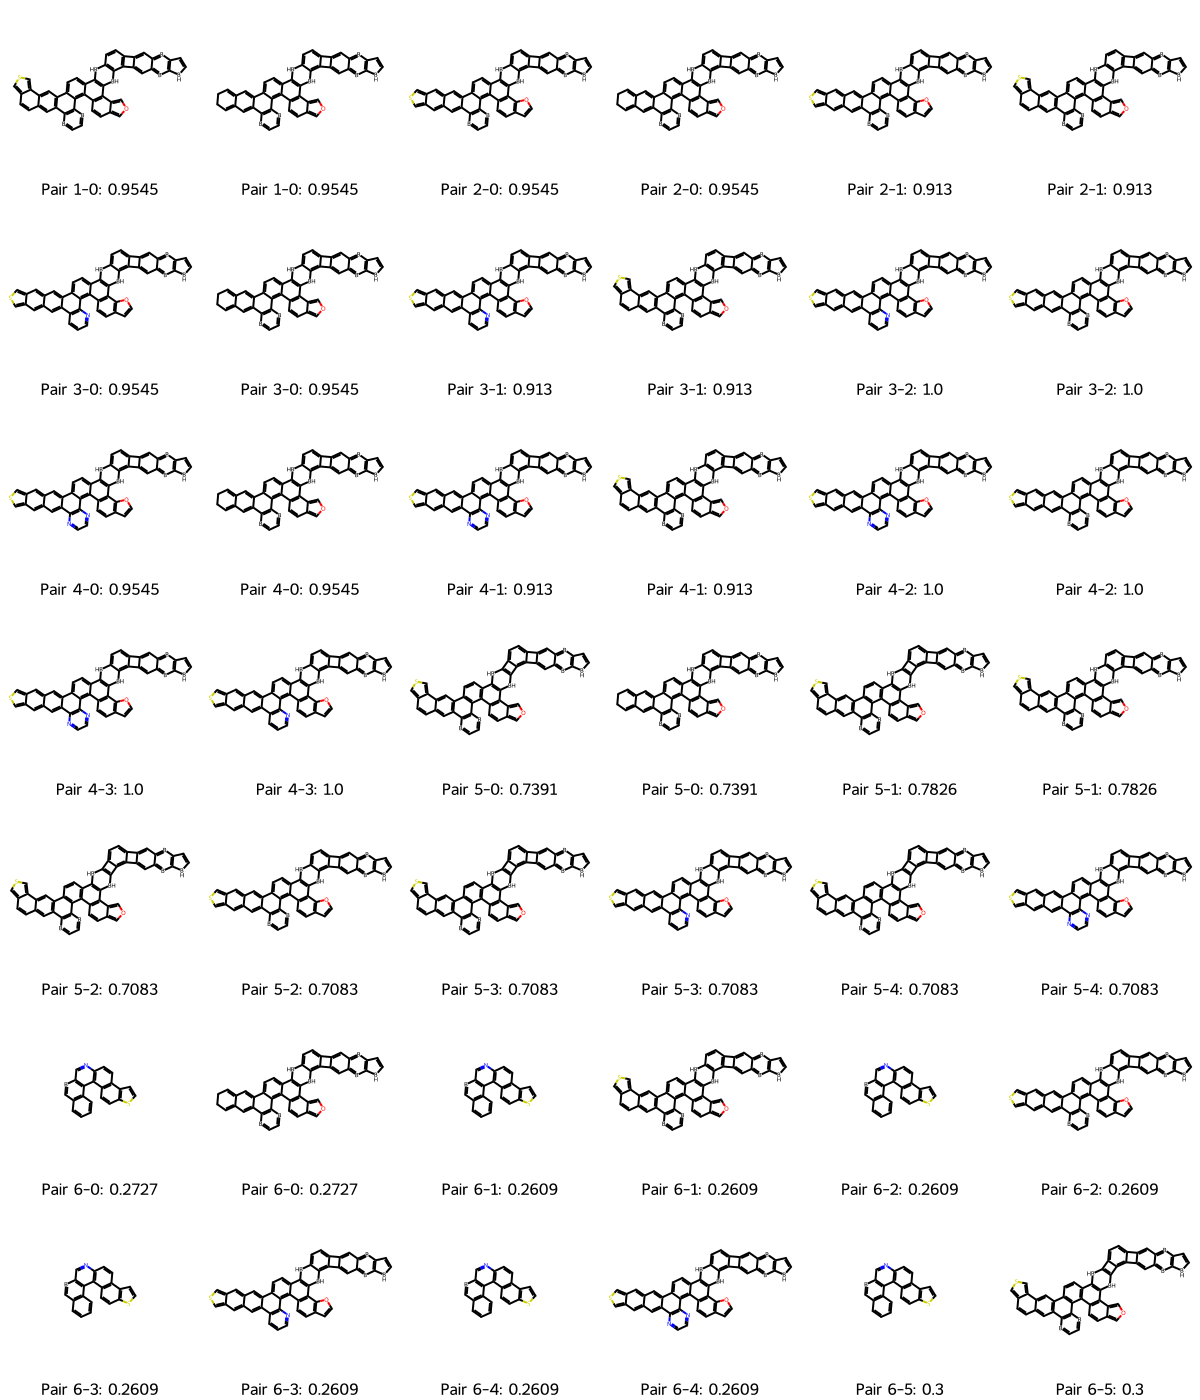

In [109]:
pairs = []
legends = []
for i in range(len(test_mols)):
    for j in range(i):
        pairs += [test_mols[i],test_mols[j]]
        legends += [f"Pair {i}-{j}: {simmat[i,j]}"]*2

Draw.MolsToGridImage(pairs,molsPerRow=6,subImgSize=(200,200),legends=legends,useSVG=True)

# Analysis of bits

The fact that the fingerprint struggles to differentiate between molecules 5 and 6 should not come as a surprise. With a composition of 387 bits, the fingerprint comprises a relatively limited number of bits to effectively encode the diverse substructures of PAHs. In order to deepen our comprehension of the fingerprint's behavior, an analysis of the bits present in each molecule was done. The section below depicts the bits on for each molecule.

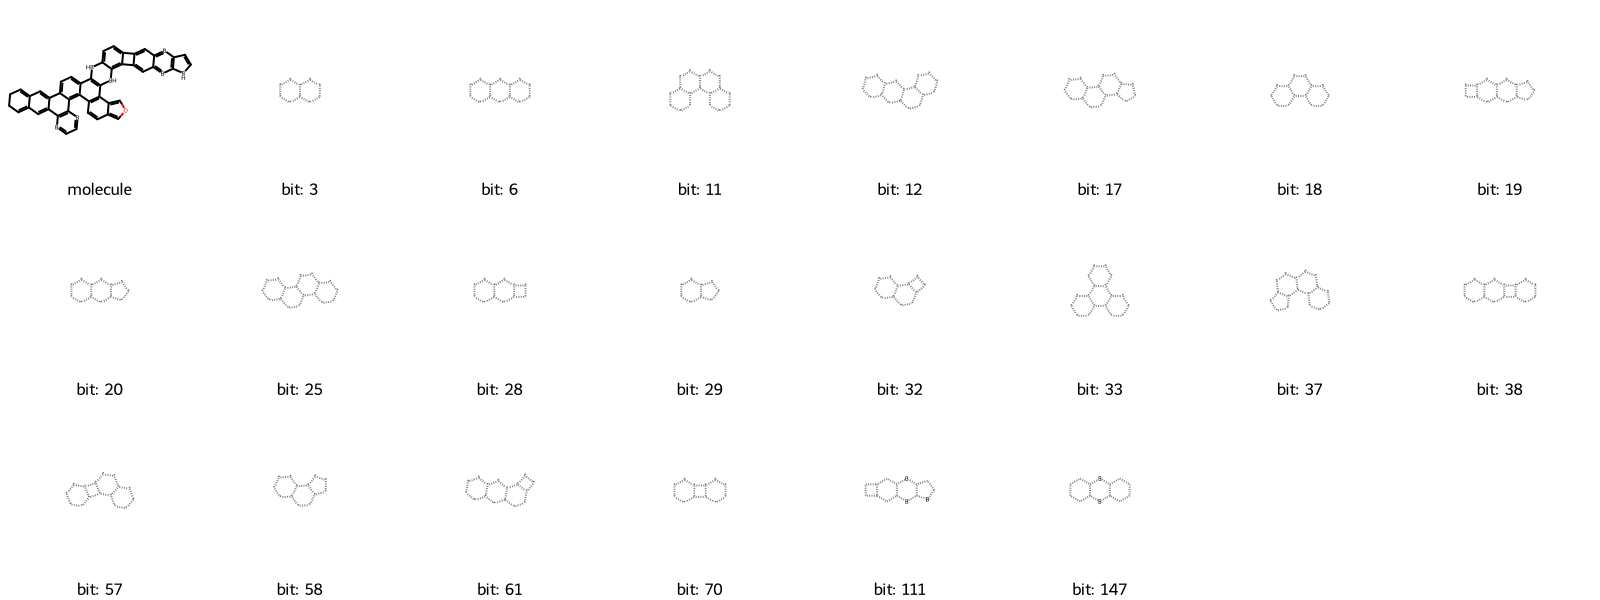

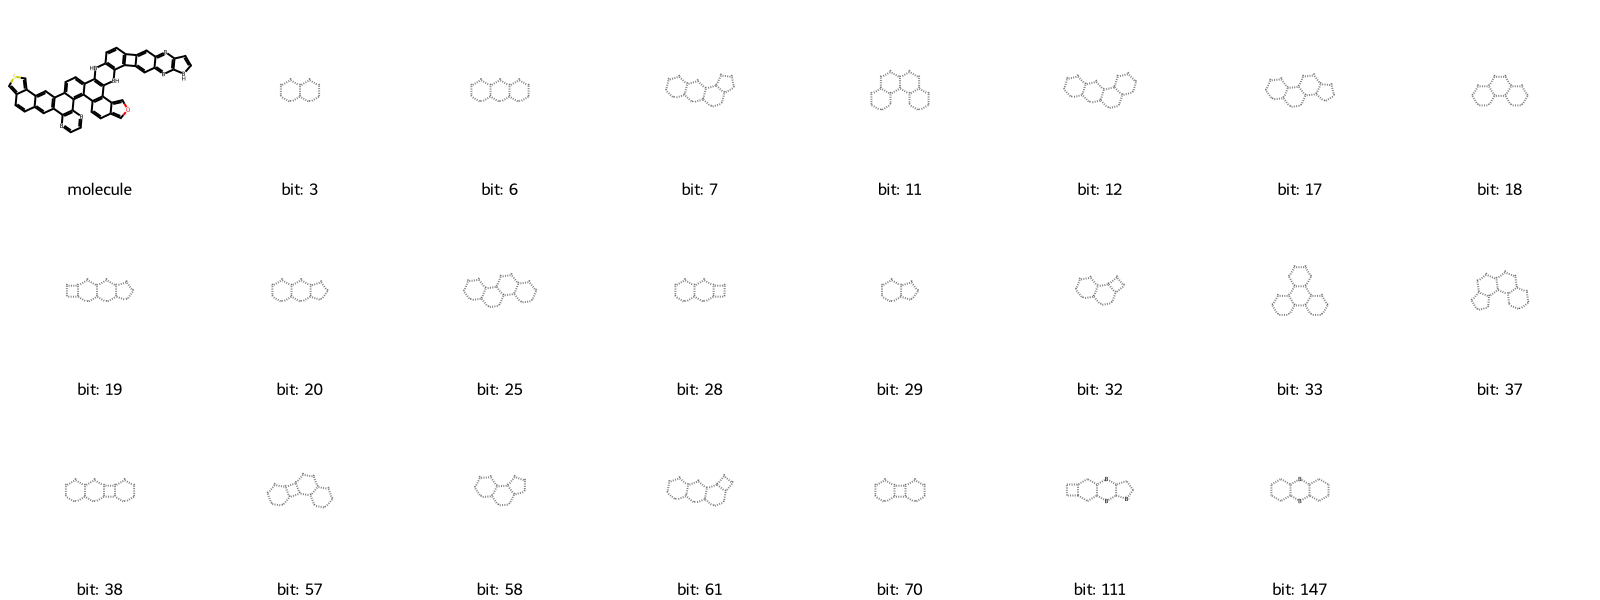

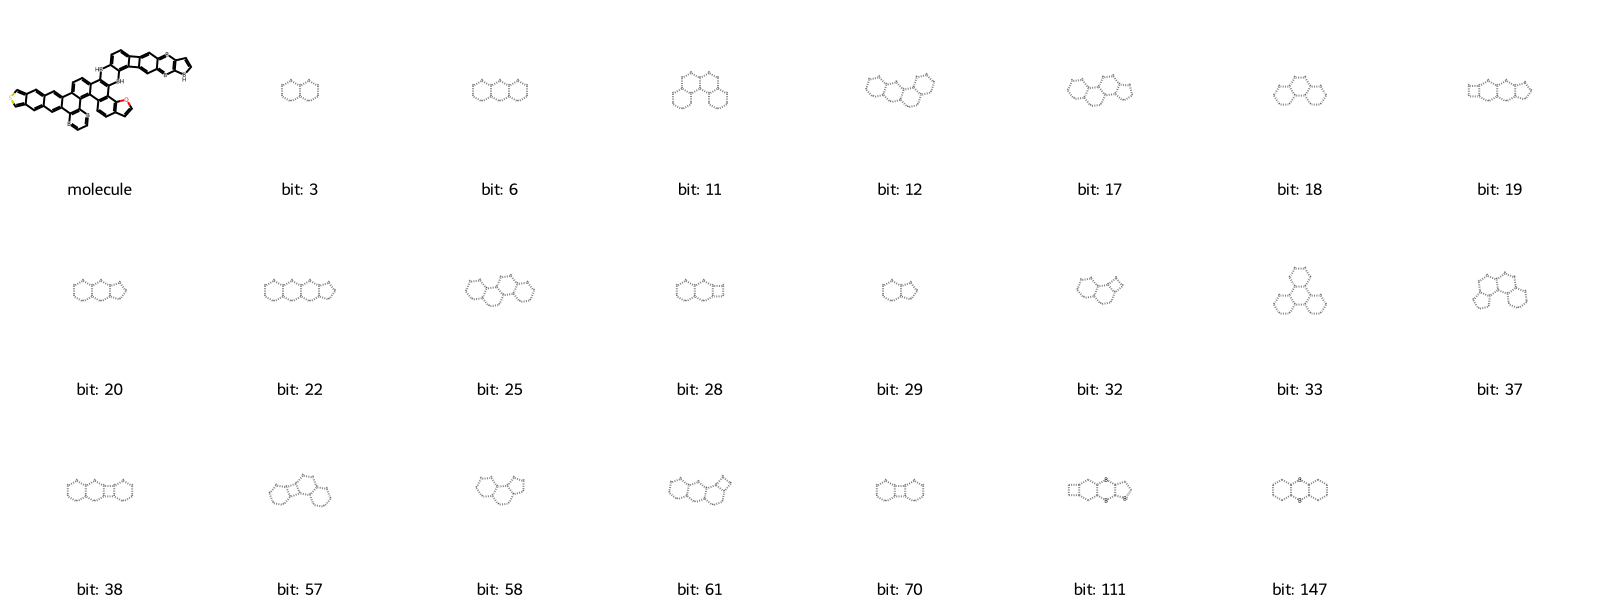

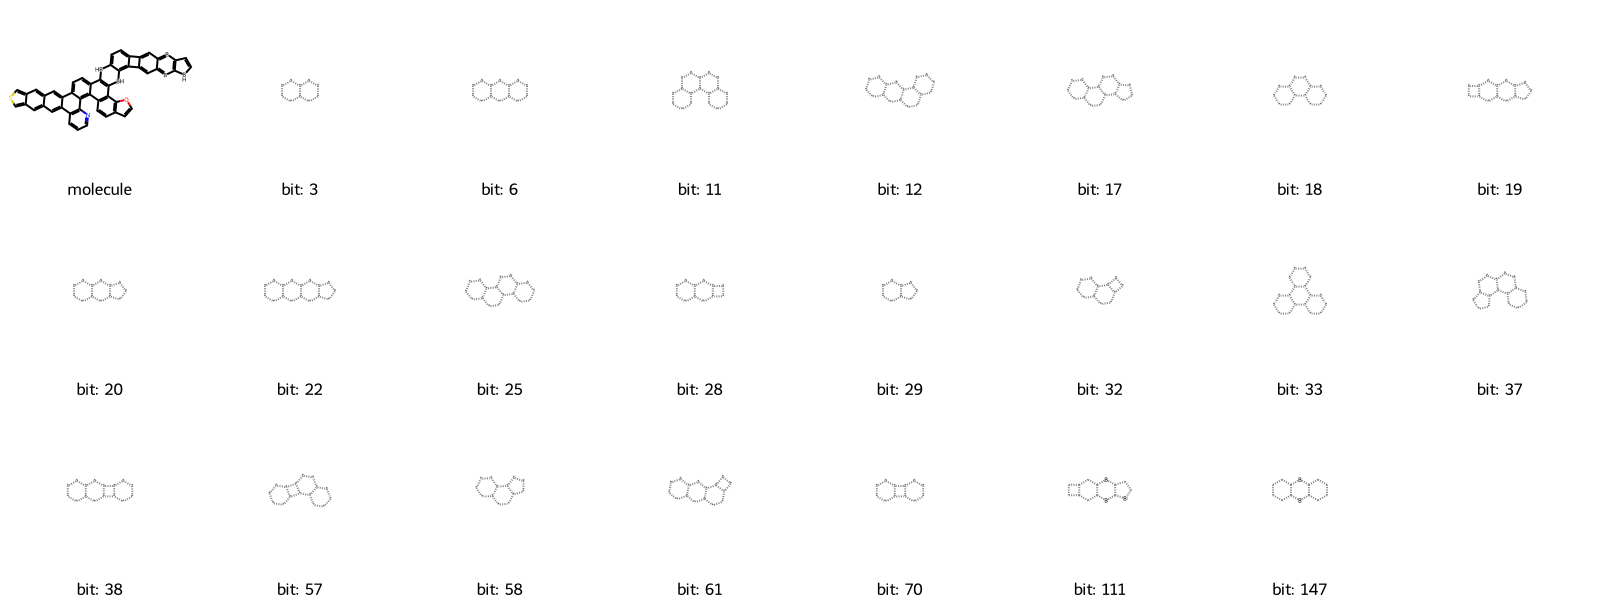

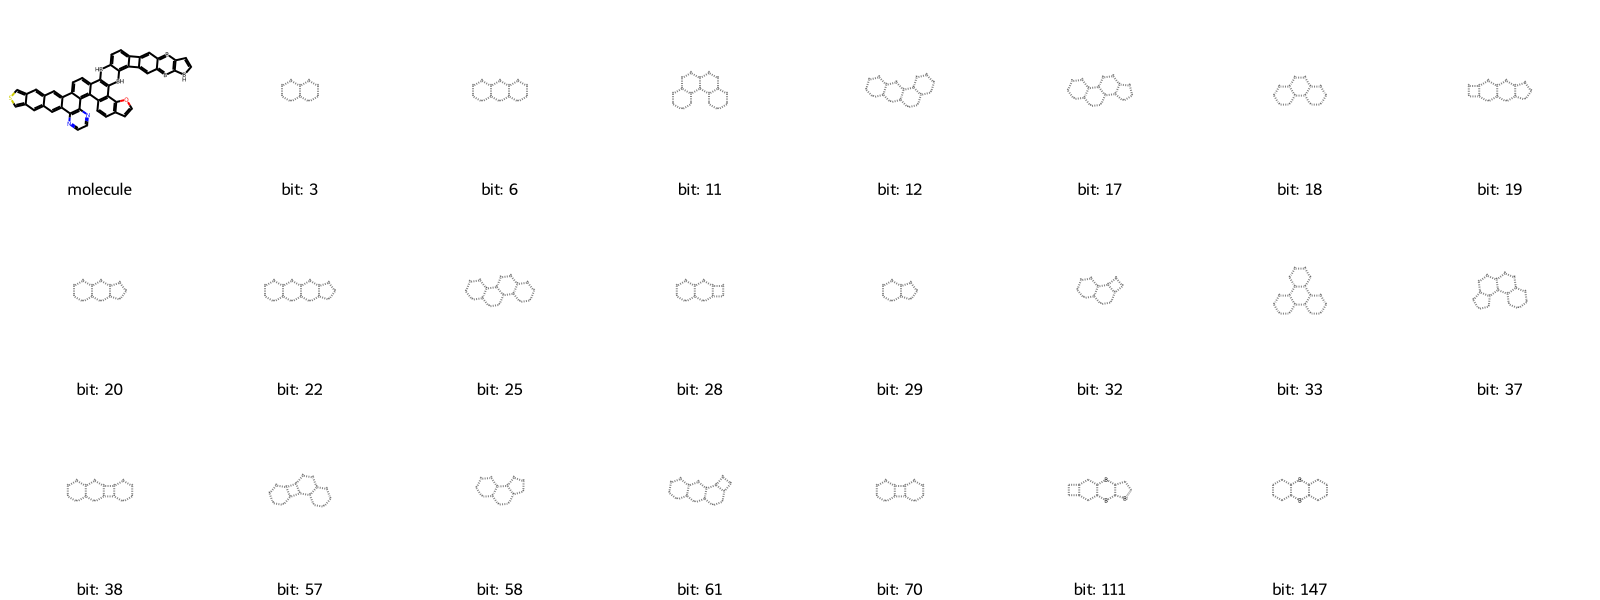

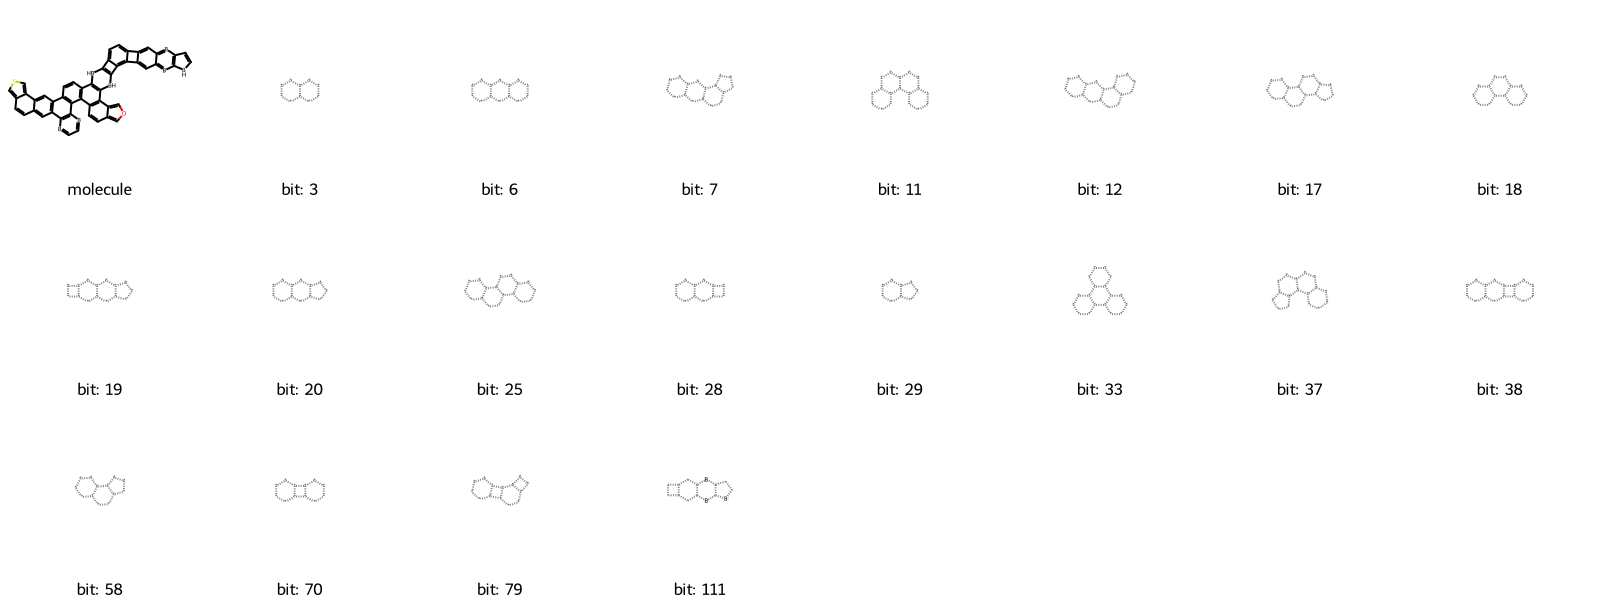

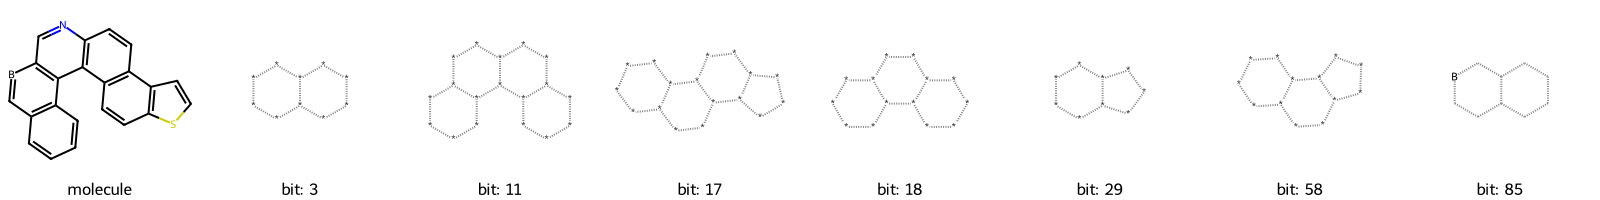

In [111]:
from typing import List, Dict
import PIL

def get_mols_to_grid_image(mol: Chem.Mol, bitsOn: List[str], smarts_patterns: Dict) -> PIL.Image:
    """
    Get a grid image of a molecule and the smarts patterns that are On (1) in the fingerprint.

    Parameters:
    ----------
    mol: rdkit.Chem.rdchem.Mol
        The molecule to draw
    bitsOn: List[str]
        List of bits On (1) for each smarts pattern in `smarts_patterns`
    smarts_patterns: dict
        Dictionary of smarts patterns used to generate the fingerprint
        
    Returns:
    -------
    img: PIL.Image
        A PIL Image object of the grid image
    """
    bits = [mol]
    legends = ["molecule"]
    bits += [smarts_patterns[bit] for bit in bitsOn] 
    legends += [f"bit: {bit}" for bit in bitsOn]
    bits = [prepare_mol(bit) for bit in bits]
    img = Draw.MolsToGridImage(bits, molsPerRow=8, subImgSize=(200, 200), useSVG=True, legends=legends)
    return img

def prepare_mol(mol: Chem.Mol) -> Chem.Mol:
    """
    Prepare the molecules for drawing. If the molecule cannot be kekulized, then
    a partial sanitization is performed.
    
    Parameters:
    ----------
    mol: rdkit.Chem.rdchem.Mol
        The molecule to draw

    Returns:
    -------
    mol_draw: rdkit.Chem.rdchem.Mol
        A molecule prepared for drawing
    """
    try:
        mol_draw = Draw.rdMolDraw2D.PrepareMolForDrawing(mol)
    except:
        mol_draw = Draw.rdMolDraw2D.PrepareMolForDrawing(mol, kekulize=False)
        Chem.SanitizeMol(mol_draw, Chem.SANITIZE_ALL ^ Chem.SANITIZE_KEKULIZE)
    return mol_draw

for mol in test_mols:
    fp = get_fingerprint(mol)
    get_mols_to_grid_image(mol, fp, smarts_patterns)

The figure above shows all the bits on. It is easily noted that the most prominent bits are those that encode the caffolds. This is expected as the scaffolds are the most common substructures in the dataset. However, it is also noted that the bits that encode the substructures are not very prominent. This is likely due to the fact that the substructures are very unique and are not present in many molecules. This is a problem that needs to be addressed in the future.

The above figures shows the active bits. It's easily noted that the most prominent bits correspond to those encoding the scaffolds. This outcome aligns with expectations, as scaffolds represent the prevailing substructures within the dataset. However, a notable observation is that the bits associated with the substructures themselves do not exhibit significant prominence. This outcome can likely be attributed to the lack of exhaustivenes in the generation of substructures patterns, rendering them present in relatively few molecules. 

# Future direction of improvement
- Enrich the fingerprint by encompassing a more exhaustive list of substructures. This can involve a comprehensive inclusion of all possible size-2 substructures within the chemical space under consideration.
- Focus exclusively on the scaffolds and expand the fingerprint's scope via an atom-pair/block-pair approach.
- Generate a GOR representation for the molecules, subsequently employing it to construct a circular fingerprint.